In [1]:
import vtk
import numpy as np
from vtk.util import numpy_support as VN
import matplotlib.pyplot as plt
from vtk.numpy_interface import dataset_adapter as dsa
import time
import sys
from hyperspy.learn.rpca import rpca_godec, orpca
sys.path.append('../')
from r_pca import *


##########################################################################
# Function definitions

def read_velocity_data(input_dir, filename, reader, t_1, t_n, velocity_flag,velocity_field):
# Read velocity data from file
# Inputs:
# input_dir - input directory location
# filename - velocity timeseries filename 
# reader - vtk reader
# t_1 - first timestep to read
# t_n - last timestep to read
# Outputs:
# X - data matrix containing the velocity data
# mesh - mesh object containing the mesh

    print('Reading velocity data and mesh from:', input_dir + filename)

    velocity_list = []
    for i in range(t_1,t_n,1):
        reader.SetFileName(input_dir+filename+str(i)+'.vtu')
        reader.Update()
        output = reader.GetOutput()
        # f_18 is the name of the velocity vector dataset assigned by FEniCS for this case
        # Vorticity is the name of the vorticity vector
        if velocity_flag:
            velocity_dataset = output.GetCellData().GetArray(velocity_field)
        #else:
        #    velocity_dataset = output.GetPointData().GetArray("Vorticity")
        velocity = VN.vtk_to_numpy(velocity_dataset)
        velocity_vec = np.reshape(velocity,(-1,1))
        velocity_list.append(velocity_vec)

    # arrange the velocity data into a big data matrix
    X = np.asarray(velocity_list)
    X = X.flatten('F')

    X = np.reshape(X,(-1,t_n-t_1))
    # rows of X correspond to velocity components at spatial locations
    # columns of X correspond to timesteps
    #     t_1 t_2.  .  t_end
    # X = [u  u  .  .  .]  (x_1,y_1)
    #     [v  v  .  .  .]  (x_1,y_1)
    #     [w  w  .  .  .]  (x_1,y_1)
    #     [u  u  .  .  .]  (x_2,y_2)
    #     [v  v  .  .  .]  (x_2,y_2) 
    #     [w  w  .  .  .]  (x_2,y_2)
    #     [.  .  .  .  .]   .
    #     [.  .  .  .  .]   .
    #     [.  .  .  .  .]   .

    # read the mesh for later visualization and saving data
    mesh = reader.GetOutput()

    return X, mesh


def convert3Dto2D_data(X):    
# If the problem is 2D, the w component of the velocity will be all zeros
# These can be deleted to have a smaller data matrix in size
# Input:
# X - velocity data matrix with 3 velocity components
# Output:
# X2D - velocity data matrix with 2 velocity components
#
#       t_1 t_2.  .  t_end
# X2D = [u  u  .  .  .]  (x_1,y_1)
#       [v  v  .  .  .]  (x_1,y_1)
#       [u  u  .  .  .]  (x_2,y_2)
#       [v  v  .  .  .]  (x_2,y_2) 
#       [.  .  .  .  .]   .
#       [.  .  .  .  .]   .
#       [.  .  .  .  .]   . 

    X2D = np.delete(X, list(range(2,X.shape[0],3)),axis = 0)
    return X2D


def convert3Dto1D_data(X):
# If vorticity is used, two of its components are zero and only the z component should be used
# Input:
# X - vorticity data matrix with 3 vorticity domponents
# Output:
# X1D - vorticity data matrix with 1 vorticity compononent
#       t_1 t_2.  .  t_end
# X1D = [w  w  .  .  .]  (x_1,y_1)
#       [w  w  .  .  .]  (x_2,y_2)
#       [w  w  .  .  .]  (x_3,y_3)
#       [.  .  .  .  .]   .
#       [.  .  .  .  .]   . 

    X1D = X[2::3,:]
    # sometimes NaN-s appear for some reason, replace these with 0s
    X1D[np.isnan(X1D)] = 0
    return X1D

def convertToMagnitude(X):
# Use velocity magnitude instead of the vector   
# Input:
# X - original data matrix with velocity vector
# Output:
# X_mag - velocity data matrix containing velocity magnitude 
#     t_1   t_2  .  .  t_end
# X_mag = [|u|  |u|  .  .  .]  (x_1,y_1)
#         [|u|  |u|  .  .  .]  (x_2,y_2)
#         [.      .  .  .  .]   .
#         [.      .  .  .  .]   .
#         [.      .  .  .  .]   .

    n = X.shape[0]
    m = X.shape[1]
    X_mag = np.zeros((int(n/3),m))

    for i in range(0,m):
        Ui = X[:,i]
        Ui = np.reshape(Ui,(-1,3))
        Ui_mag = np.sqrt(np.sum(np.square(Ui),1))
        X_mag[:,i] = Ui_mag

    return X_mag


def RearrangeDataForTranspose(X):
# Reshape data matrix for temporal reduction
# Each row contains both u and v for a given spatial location
# Each two columns contain a snapshot of u and of v
# The rows of the matrix will be taken as different data points and will be compared to each other
# Therefore, it is not fair to comapre u with v, this necessitates this reshaping
# Input:
# X - original data matrix
# Output:
# X_new - new data matrix, arranged as:
# X_new = [u  v  u  v  .]  (x_1,y_1)
#         [u  v  u  v  .]  (x_2,y_2)
#         [u  v  u  v  .]  (x_3,y_3)
#         [u  v  u  v  .]  (x_4,y_4)
#         [.  .  .  .  .]   .
#         [.  .  .  .  .]   .
#         [.  .  .  .  .]   .
#         t1 t1 t2 t2  .

    u = X[0::2,:]
    v = X[1::2,:]

    n = X.shape[0]
    m = X.shape[1]

    X_new = np.zeros((int(n/2),int(m*2)))
    for i in range(m):
        X_new[:,2*i] = u[:,i]
        X_new[:,2*i+1] = v[:,i]

    return X_new

def subtract_mean(X):
# subtract the temporal mean of the data set
# Input:
# X - original data matrix
# Output:
# X - data matrix with temporal mean subtracted
# X_mean - temporal mean of the data
    n = X.shape[0]
    m = X.shape[1]  
    X_mean = np.mean(X,1)
    for i in range(0,n):
        X[i,:] = X[i,:]-X_mean[i]

    X = (1/np.sqrt(m)* X)
    return X, X_mean



def save_modes(u, mesh, output_file, modesToSave):
# Save the spatial modes to a VTK file for visualization
# Input:
# u - matrix containing the eigenvectors
# mesh - mesh object containing the location of the mesh points
# output_file - name and location of the output vtk file for the modes
# modesToSave - number of modes to save to the VTK file


    mesh = dsa.WrapDataObject(mesh)
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(output_file)
    writer.SetInputData(mesh.VTKObject)

    if modesToSave > u.shape[1]:
        modesToSave = u.shape[1]
        print('Max number of modes is', u.shape[1])
    
    print('Saving the first',modesToSave, 'PCA modes to ',out_filename)

    for i in range(0,modesToSave,1):
        U_i = u[:,i]
        #if convertToMagnitude_flag == True:
        mesh.PointData.append(U_i, 'mode_'+str(i))
        
        #if i == 0 and subtract_mean_flag:
            #mesh.PointData.append(X_mean, 'U_mean')
            #mesh.PointData.append(X_mean[0::2], 'U_mean')       #for Transpose
            #mesh.PointData.append(X_mean[1::2], 'V_mean')       #for Transpose
        # else:
            # mesh.PointData.append(U_i[0::2], 'mode_u_'+str(i))
            # mesh.PointData.append(U_i[1::2], 'mode_v_'+str(i))
            
            # if i == 0 and subtract_mean_flag:
                # mesh.PointData.append(X_mean[0::2], 'U_mean')
                # mesh.PointData.append(X_mean[1::2], 'V_mean')

    writer.Write()


def plotSpectrum(s):
# Plot singular value spectrum
# Input:
# s - vector containing the singular values
    sigma = s
    sigma_energy = np.cumsum(sigma)

    # plot singular values and the cumulative energy
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10, 6), dpi=80)
    ax1.plot(sigma[0:100],'ko',markersize=3)
    ax1.set_xlabel('Modes')
    ax1.set_ylabel('Singular values')
    ax1.set_title('PCA')

    ax2.plot(sigma[0:100],'ko',markersize=3)
    ax2.semilogy()
    ax2.set_xlabel('Modes')
    ax2.set_ylabel('Singular values')
    ax2.set_title('PCA, semi log-plot')


    ax3.plot(sigma_energy/np.sum(sigma),'ko',markersize=3)
    ax3.set_xlabel('Modes')
    ax3.set_ylabel('Cumulative energy')
    ax3.set_title('Normalized cumulative energy')
    f.tight_layout()
    f.savefig('PCA_spectrum.png',dpi = 300)

def inverseTransform(u, s, vh, r_max):
# Perform inverse transform and map from the embedded space to the original space
# Calculate reconstruction error
# Input:
# u, s, vh - outputs of the SVD algorithm
# r_max - max number of modes to keep
# Output:
# X_reconstruced - reconstructed data with r_max modes
# err_rec - vector containing the reconstruction error for 1 to r_max modes
    err_rec = np.zeros(r_max)

    for r in range(1,r_max+1,1):
        S_r = np.diag(s[0:r])
        U_r = u[:,0:r]
        Vh_r = vh[0:r,:]
        X_reconstructed = U_r @ S_r @ Vh_r
        err_rec[r-1] = np.linalg.norm(X-X_reconstructed)**2/np.linalg.norm(X)**2
    return X_reconstructed, err_rec

def plotAndSaveReconstruction(err_rec, save_rec, X, X_reconstructed, mesh, out_filename, plotToScreen, convertToMagnitude_flag, velocity_flag):
# Plot the reconstruction error as a function of torg_vox_05mmhe number of modes used
# Input:
# err_rec - vector containing the reconstruction error for 1 to r_max modes
# save_rec - if True: save the original and reconstructed fields in a vtk file
#            !caution - for large data sets these file will be also large!
# X - original data matrix
# X_reconstructed - reconstructed data matrix with r_max modes
# mesh - mesh object containing the location of the mesh points
# out_filename - name and location of the output vtk files for the reconstruction
# plotToScreen - if True: show the reconstruction plot on the display
# convertToMagnitude_flag - if True: velocity magnitude was used
#                         - if False: velocity vector (u,v) was used
# Velocity flag - if True: velocity data was used 
#                 if False: vorticity data was used

    plt.figure(2)
    plt.plot(range(1,len(err_rec)+1),err_rec,linestyle='--', marker='o')
    plt.xlabel('Modes used for reconstruction')
    plt.ylabel('Relative reconstruction error')
    plt.title('PCA reconstruction error')
    plt.semilogy()
    plt.tight_layout()
    plt.savefig('PCA_rec_error.png',dpi = 200)
    if(plotToScreen):
        plt.show()

    if(save_rec):
        meshNew = dsa.WrapDataObject(mesh)

        if convertToMagnitude_flag or not velocity_flag:
            for j in range(0,X.shape[1]):
                meshNew.PointData.append(X_reconstructed[:,j], 'reconstructed')
                meshNew.PointData.append(X[:,j], 'original')
                writer = vtk.vtkUnstructuredGridWriter()
                writer.SetFileName(out_filename + str(j)+ '.vtk')
                writer.SetInputData(meshNew.VTKObject)
                writer.Write()
        # elif not transpose_flag:
        #     for j in range(0,X.shape[1]):
        #         meshNew.PointData.append(X_reconstructed[0::2,j], 'u_reconstructed')
        #         meshNew.PointData.append(X[0::2,j], 'u_original')
        #         meshNew.PointData.append(X_reconstructed[1::2,j], 'v_reconstructed')
        #         meshNew.PointData.append(X[1::2,j], 'v_original')
        #         writer = vtk.vtkUnstructuredGridWriter()
        #         writer.SetFileName(out_filename + str(j)+ '.vtk')
        #         writer.SetInputData(meshNew.VTKObject)
        #         writer.Write()
        else:
            for j in range(0,int(X.shape[1]/2)):
                meshNew.PointData.append(X_reconstructed[:,2*j], 'u_reconstructed')
                meshNew.PointData.append(X[:,2*j], 'u_original')
                meshNew.PointData.append(X_reconstructed[:,2*j+1], 'v_reconstructed')
                meshNew.PointData.append(X[:,2*j+1], 'v_original')
                writer = vtk.vtkUnstructuredGridWriter()
                writer.SetFileName(out_filename + str(j)+ '.vtk')
                writer.SetInputData(meshNew.VTKObject)
                writer.Write()

In [2]:
##########################################################################

#input_dir = "/scratch/hc595/cylinder_flow/CFD_results/navier_stokes_cylinder/downsampled_cropped/"
input_dir = "/home/hunor/PhD/Phase2/MRI/MRI_data_vtk/"
# Velocity flag - if True: use velocity data
#                 if False: use vorticity data
velocity_flag = True
if velocity_flag:
    filename = 'box_aneurysm_velocity_'
else:
    filename = 'vorticity_'
reader = vtk.vtkXMLUnstructuredGridReader()

t_transient = 0
t_end = 15

velocity_field = 'u'
Xu, mesh = read_velocity_data(input_dir, filename, reader, t_transient, t_end, velocity_flag, velocity_field)
velocity_field = 'v'
Xv = read_velocity_data(input_dir, filename, reader, t_transient, t_end, velocity_flag, velocity_field)[0]
velocity_field = 'w'
Xw = read_velocity_data(input_dir, filename, reader, t_transient, t_end, velocity_flag, velocity_field)[0]


Reading velocity data and mesh from: /home/hunor/PhD/Phase2/MRI/MRI_data_vtk/box_aneurysm_velocity_
Reading velocity data and mesh from: /home/hunor/PhD/Phase2/MRI/MRI_data_vtk/box_aneurysm_velocity_
Reading velocity data and mesh from: /home/hunor/PhD/Phase2/MRI/MRI_data_vtk/box_aneurysm_velocity_


In [3]:
# # convertToMagnitude_flag 
# #                   if True: velocity magnitude will be used
# #                   if False: velocity vector will be used
# convertToMagnitude_flag = False


# if convertToMagnitude_flag and velocity_flag:
#     X = convertToMagnitude(X)

In [4]:
Xu.shape

(50505, 15)

Data matrix X is n by m: 151515 x 15
u is  (151515, 15)
s is  (15,)
vt is  (15, 15)
Time elapsed for PCA: 0.10446023941040039  s


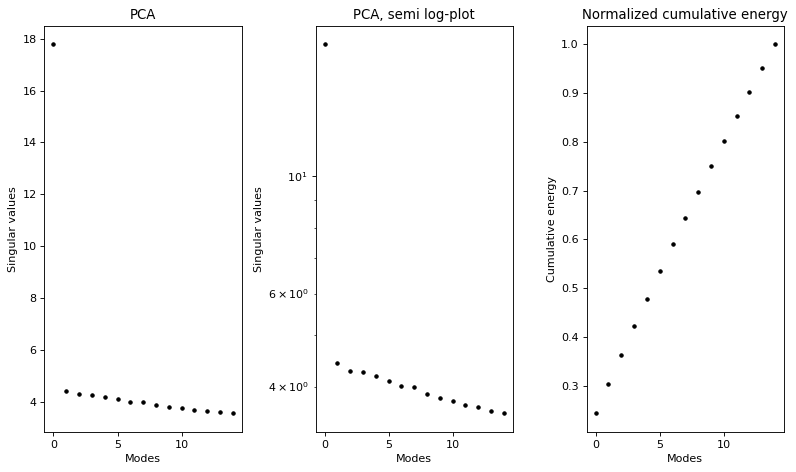

In [5]:
subtract_mean_flag = False

X = np.append(np.append(Xu,Xv,axis = 0),Xw,axis = 0)
#X = Xu
n = X.shape[0]
m = X.shape[1]
print("Data matrix X is n by m:", n, "x", m)
# Normalize to [0,1]
# u=1
# l=0
#X = (X-np.min(X))/(np.max(X)-np.min(X))*(u-l)+l
#Add noise
#fraction_data_noise = 0.1
#noise_level = 0.1
#n_noise = np.floor(fraction_data_noise*n*m)
#X_reshaped = np.reshape(X,(n*m,1))
#X_noisy = X_reshaped.copy()
#np.random.seed(seed = 42)
#rand_interval = np.random.permutation(n*m)
#noise_mask = rand_interval[0:int(n_noise)]
#X_noisy[noise_mask] = X_noisy[noise_mask] + noise_level*np.random.randn(X_noisy[noise_mask].size,1)
#X_noisy = X_noisy.reshape(n,m)
#X_noisy = np.clip(X_noisy,0.0, None)

#print('|X-X_noisy|=',np.linalg.norm(X-X_noisy,'fro'))


# Perform PCA/SVD
start = time.time()
u, s, vh = np.linalg.svd(X,full_matrices = False)
print("u is ", u.shape)
print("s is ", s.shape)
print("vt is ", vh.shape)
end = time.time()
print('Time elapsed for PCA:',end - start, ' s')

# plot singular value spectrum and normalized cumulative energy
plotSpectrum(s)

# save POD modes in a VTK file
out_filename = 'PCA_modes.vtk'
modesToSave = 8
#save_modes(u, mesh, out_filename, modesToSave)

In [9]:
start_rpca = time.time()
# lmbda = 5e-4
# print('Lambda:',lmbda)
rpca = R_pca(X*6)#, lmbda = lmbda) #scale by a factor of 6 to match CFD data scale!
L, S = rpca.fit(max_iter=300, iter_print=100, tol = 1e-18)
end_rpca = time.time()
print('Time elapsed for RPCA:',end_rpca - start_rpca, ' s')

print('Error |X-L|:'+ str(np.linalg.norm(X-L,'fro')))

Mu:6.927012215936799
Lambda:0.0025690478002572473
iteration: 1, error: 0.22271465276779026
iteration: 100, error: 0.000793640494663179
iteration: 200, error: 0.0012605787954395218
iteration: 300, error: 0.007424423186128879
Time elapsed for RPCA: 25.62628149986267  s
Error |X-L|:71.44187786530532


In [10]:
Lu = L[0:int(n/3),:]
Lv = L[int(n/3):2*int(n/3),:]
Lw = L[2*int(n/3):,:]

In [11]:
#if subtract_mean_flag:
#    L, X_mean = subtract_mean(L)

#urpca,srpca,vhrpca = np.linalg.svd(L,full_matrices = False)
#out_filename_rpca = 'RPCA_modes.vtk'
#modesToSave = 8
#mesh = dsa.WrapDataObject(mesh)
#writer = vtk.vtkUnstructuredGridWriter()
#writer.SetFileName(out_filename_rpca)
#writer.SetInputData(mesh.VTKObject)
    
#print('Saving the first',modesToSave, 'RPCA modes to ',out_filename_rpca)

#for i in range(0,modesToSave,1):
#    U_i = urpca[:,i]
    #if convertToMagnitude_flag == True:Result
#    mesh.PointData.append(U_i, 'mode'+str(i))


# out_filename = 'noisy_data/RPCA_reconstruction_lambda'+str(lmbda)+'_'
out_filename = 'noisy_data/RPCA_reconstruction_box_lambda_default_scaled'
print('Saving the noisy velocity field to ',out_filename)
meshNew = dsa.WrapDataObject(mesh)
#mesh.GetCellData().RemoveArray('u')
for j in range(0,m):
    meshNew.CellData.append(Xu[:,j], 'u')
    meshNew.CellData.append(Lu[:,j],'u_low_rank_reconstructed')
    meshNew.CellData.append(Xv[:,j], 'v')
    meshNew.CellData.append(Lv[:,j],'v_low_rank_reconstructed')
    meshNew.CellData.append(Xw[:,j], 'w')
    meshNew.CellData.append(Lw[:,j],'w_low_rank_reconstructed')
    writer = vtk.vtkXMLUnstructuredGridWriter()
    writer.SetFileName(out_filename + str(j)+ '.vtu')
    writer.SetInputData(meshNew.VTKObject)
    writer.Write()



Saving the noisy velocity field to  noisy_data/RPCA_reconstruction_box_lambda_default_scaled


u is  (50505, 15)
s is  (15,)
vt is  (15, 15)
Time elapsed for PCA: 0.02000117301940918  s


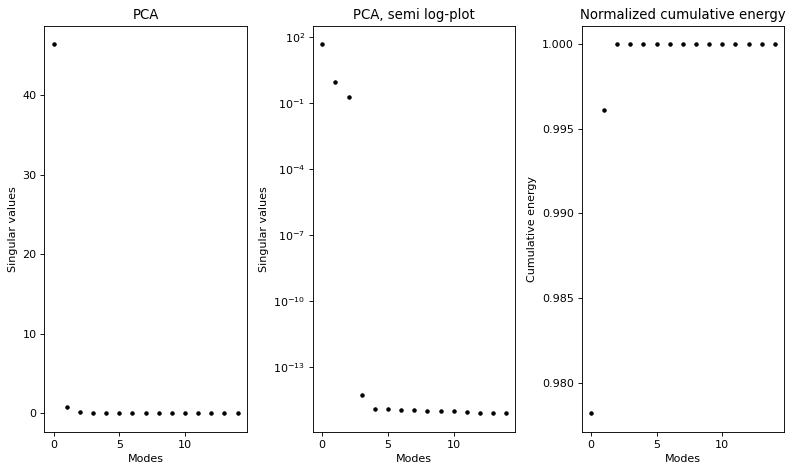

In [12]:
#PCA on the low-rank matrix L
start = time.time()
u, s, vh = np.linalg.svd(Lu,full_matrices = False)
print("u is ", u.shape)
print("s is ", s.shape)
print("vt is ", vh.shape)
end = time.time()
print('Time elapsed for PCA:',end - start, ' s')

# plot singular value spectrum and normalized cumulative energy
plotSpectrum(s)

In [21]:
out_filename = 'RPCA_modes/RPCA_modes.vtk'
modesToSave = 8
print('Saving the RPCA u velocity modes to ',out_filename)
meshNew = dsa.WrapDataObject(mesh)
#mesh.GetCellData().RemoveArray('u')
for j in range(0,modesToSave):
    meshNew.CellData.append(u[:,j], 'mode'+str(j))
    writer = vtk.vtkUnstructuredGridWriter()
    writer.SetFileName(out_filename + str(j)+ '.vtk')
    writer.SetInputData(meshNew.VTKObject)
    writer.Write()

Saving the RPCA u velocity modes to  RPCA_modes/RPCA_modes.vtk
